In [ ]:
from mesa import Agent, Model
from mesa.space import NetworkGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import networkx as nx
import graph_init
import pandas as pd
import station as st

import network_example as ne
import numpy as np
import pathfinding as pf
import graph_functions as gf
import matplotlib.pyplot as plt
import particle_swarm as ps

In [11]:
class Commuter(Agent):
    def __init__(self, model, current_pos, distance_left, intermediate_node, destination):
        super().__init__(model)
        self.destination = destination # The agent's destination
        self.intermediate_node = intermediate_node # The agent's intermediate node needed to reach the destination
        self.distance_left = distance_left # The distance left to the intermediate node, in terms of time
        self.current_pos = current_pos # The agent's current position
        self.biking = False # Whether the agent is currently biking
        self.stopwatch = 0 # The agent's stopwatch, used to measure time spent completing a trip
        self.walking_time = pf.walk_cost(self.model.grid.G, self.current_pos, self.destination, walk_multiplier=self.model.walking_multiplier) # The time it takes to walk to the destination directly from the initial destination
        self.time_saved = [[self.walking_time]] # List of lists, where each list contains the time needed to walk directly, and time actually spent walking/biking
        self.park_failures = 0 # Number of times the agent has failed to park a bike bc no spots were available

        assert self.model.grid.G.nodes[self.current_pos]['type'] == 'destination', "Agent must start at a destination"
        
    def step(self):
        # update the agent's position and stopwatch for current trip
        self.current_pos = self.model.get_node(self)
        self.stopwatch += 1

        # If the agent has reached the intermediate node, set new start node
        if self.distance_left <= 0:
            # If the agent has reached the intermediate node, set new start node
            self.current_pos = self.intermediate_node
            self.model.grid.move_agent(self, self.current_pos)
            
            if self.model.grid.G.nodes[self.current_pos]['type'] == 'station':
                self.model.grid.G.nodes[self.current_pos]['data'].popularity += 1

            # Return bike if the agent is at the intended station and there are spots available
            # if self.biking and self.model.grid.G.nodes[self.current_pos]['type'] == 'station' and self.model.grid.G.nodes[self.current_pos]['data'].get_spot_availability():
            #     self.model.grid.G.nodes[self.current_pos]['data'].return_bike()
            #     self.biking = False

            # If the agent has reached the destination, set new destination
            # Else, the agent will rent a bike if it is at a station and there are bikes available
            if self.current_pos == self.destination:
                self.time_saved[-1].append(self.stopwatch)
                self.stopwatch = 0
                self.destination = self.model.sample_destination(self.current_pos)
                self.walking_time = pf.walk_cost(self.model.grid.G, self.current_pos, self.destination, walk_multiplier=self.model.walking_multiplier)
                self.time_saved.append([self.walking_time])
            elif not(self.biking) and self.model.grid.G.nodes[self.current_pos]['type'] == 'station' and self.model.grid.G.nodes[self.current_pos]['data'].get_bike_availability():
                # self.model.grid.G.nodes[self.current_pos]['data'].rent_bike()
                # self.biking = True
                pass

            #### commented this out, Dev's implementation of parking failures changed this and is below
            # elif self.biking and self.model.grid.G.nodes[self.current_pos]['type'] == 'station' and self.model.grid.G.nodes[self.current_pos]['data'].get_spot_availability():
            #     self.model.grid.G.nodes[self.current_pos]['data'].return_bike()
            #     self.biking = False

            ### testing park failures
            elif self.biking and self.model.grid.G.nodes[self.current_pos]['type'] == 'station':
                if self.model.grid.G.nodes[self.current_pos]['data'].get_spot_availability():
                    self.model.grid.G.nodes[self.current_pos]['data'].return_bike()
                    self.biking = False
                else:
                    self.park_failures += 1

            # Set new intermediate node
            if self.model.grid.G.nodes[self.current_pos]['type'] == 'destination':
                path = pf.pathfind(self.model.grid.G, self.current_pos, self.destination, False, walk_multiplier=self.model.walking_multiplier)
            else:
                bike = self.model.grid.G.nodes[self.current_pos]['data'].get_bike_availability()
                path = pf.pathfind(self.model.grid.G, self.current_pos, self.destination, bike, walk_multiplier=self.model.walking_multiplier)
                if not(path[1]) and self.biking:
                    path = pf.bike_std(self.model.grid.G, self.current_pos, self.destination)

            self.intermediate_node = path[0]
            
            if path[1]:
                self.distance_left = self.model.grid.G[self.current_pos][self.intermediate_node]['weight']
                if not(self.biking):
                    self.model.grid.G.nodes[self.current_pos]['data'].rent_bike()
                    self.biking = True
            else:
                self.distance_left = self.model.grid.G[self.current_pos][self.intermediate_node]['weight'] * self.model.walking_multiplier
        else:
            self.distance_left -= 1        

    
    def get_agent_position(self):
        return self.current_pos
    
    def get_distance_left(self):
        return self.distance_left
    
    def get_agent_destination(self):
        return self.destination
    
    def get_intermediate_node(self):
        return self.intermediate_node
    
    def get_stopwatch(self):
        return self.stopwatch
    
    def get_station_info(self):
        if self.model.grid.G.nodes[self.current_pos]['type'] == 'station':
            return self.model.grid.G.nodes[self.current_pos]['data'].available_bikes
        else:
            return "at dest"
    
    def get_next_station_info(self):
        if self.model.grid.G.nodes[self.intermediate_node]['type'] == 'station':
            return self.model.grid.G.nodes[self.intermediate_node]['data'].available_bikes
        else:
            return "no intermed"
    
    def get_all_station_info(self):
        numword = {0: 'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four'}
        return [str(station) + ":" +str({self.model.grid.G.nodes[station]['data'].available_bikes}) for station in self.model.stations]

    def bike_boolean(self):
        return self.biking
    
    def park_failure(self):
        return self.park_failures

class MyModel(Model):
    def __init__(self, n_agents, seed=None, G=ne.basic_graph()[0]):
        # Initialize the model, set up random seeds for mesa and numpy
        super().__init__(seed=seed)
        self.rng = np.random.default_rng(seed)

        # graph initialization and time multiplier for walking
        g = G
        self.walking_multiplier = 10
        self.grid = NetworkGrid(g)
        
        # data collector
        self.datacollector = DataCollector(
            agent_reporters={"Position": lambda agent: agent.get_agent_position(),
                             "Distance_Left": lambda agent: agent.get_distance_left(),
                             "Intermediate_Node": lambda agent: agent.get_intermediate_node(),
                             "Destination": lambda agent: agent.get_agent_destination(),
                             "Stopwatch": lambda agent: agent.get_stopwatch(),
                            #  "Cur Station Capacity": lambda agent: agent.get_station_info(),
                            #  "Next Station Capacity": lambda agent: agent.get_next_station_info(),
                             "All Station Capacity": lambda agent: agent.get_all_station_info(),
                             "Biking": lambda agent: agent.bike_boolean(),
                             "Park Failures": lambda agent: agent.park_failure(),
                             })
        
        # storing all stations and destination node indices
        self.stations = pf.get_stations(self.grid.G)
        self.destinations = pf.get_destinations(self.grid.G)

        # destination weights for sampling
        self.destination_w = ne.basic_weights()

        # Create agents and place them on the grid
        for i in range(1, n_agents + 1):
            node_id = self.random.choice(self.destinations)
            destination_node = self.sample_destination(node_id)
            path = pf.pathfind(self.grid.G, node_id, destination_node, False, walk_multiplier=self.walking_multiplier)
            intermediate_node = path[0]
            distance_left = self.grid.G[node_id][intermediate_node]['weight'] * self.walking_multiplier

            commuter = Commuter(self, current_pos=node_id, distance_left=distance_left, intermediate_node=intermediate_node, destination=destination_node)

            self.grid.place_agent(commuter, node_id)
            
        self.datacollector.collect(self)
    
    def get_node(self, agent):
        """
        Returns the node ID of the given agent if it is found in the grid

        Parameters
        ----------
        agent : Agent
            The agent whose node ID is to be found

        Returns
        -------
        node_id : int
            The node ID of the given agent
        """
        # Iterate over all node IDs in the graph
        for node_id in self.grid.G.nodes():
            # Get the agents at the current node
            agents_at_node = self.grid.get_cell_list_contents([node_id])
            # If the given agent is found at this node, return the node ID
            if agent in agents_at_node:
                return node_id
        return None  # If the agent is not found in any node

    def sample_destination(self, current_pos):
        """
        Sample a destination for an agent to travel to

        Parameters
        ----------
        current_pos : int
            The current position index of the agent
        
        Returns
        -------
        destination: int
            The destination node index
        """
        while True:
            destination = self.rng.choice(self.destinations, p=ne.basic_weights())
            if destination != current_pos:
                return destination
            
    def assign_bikes(self, bike_counts):
        """
            For each station, assign a number of bikes to the station

            Parameters
            ----------
            bike_counts : dict
                A dictionary where the keys are station indices and the values are the number of bikes to be assigned to the station

            Returns
            -------
            None
        """
        for station in self.stations:
            assert station in bike_counts, "All stations must be assigned a number of bikes"
            self.grid.G.nodes[station]['data'].assign_bikes(bike_counts[station])

    def step(self):
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)
    
    def time_saved_ratio(self):
        """
            The ratio of time traveled with biking & walking to time traveled with only walking

            Parameters
            ----------
            agent : Agent
                The agent whose time saved is inputted

            Returns
            -------
            ratio : float
                The ratio of time traveled with biking & walking to time traveled with only walking
        """
        totalwalk=0
        realtime=0
        for agent in self.agents:
            time = agent.time_saved
            for x in time:
                if len(x) == 2:
                    totalwalk += x[0]
                    realtime += x[1]
        return totalwalk, realtime, realtime/totalwalk

In [12]:
# test the model with 5 agents and full bike capacity

model = MyModel(100, seed=1)
for i in range(1000):
    model.step()

agent_data = model.datacollector.get_agent_vars_dataframe()
pd.reset_option('display.max_rows', None)
agent_data[['Distance_Left', "Position", 'Intermediate_Node', 'Destination', 'All Station Capacity', 'Biking', 'Park Failures']]

# print the 1000 index



KeyboardInterrupt: 

In [ ]:
model.time_saved_ratio()

(np.float64(105280.0), 92745, np.float64(0.8809365501519757))

Station 0 has 3 bikes
Station 1 has 3 bikes
Station 2 has 3 bikes
Station 3 has 3 bikes


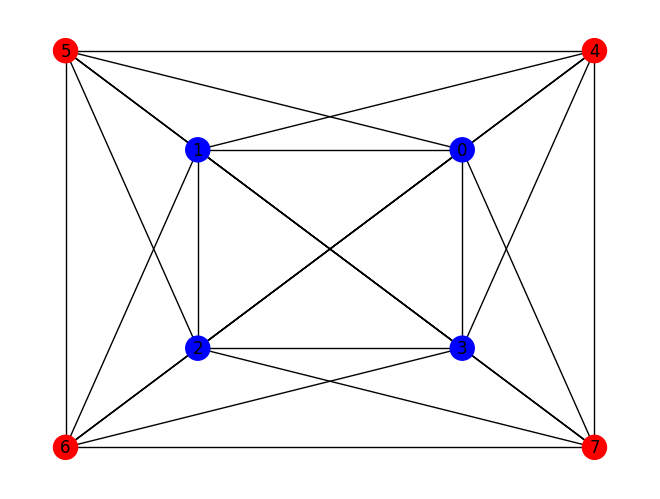

In [ ]:
n_stations = 4
G, total_nodes = ne.basic_graph()
pos = {i: total_nodes[i] for i in range(total_nodes.shape[0])}
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw(G, pos, node_color=colors, with_labels=True)
# print the number of bikes at each station
for i in range(n_stations):
    print('Station', i, 'has', G.nodes[i]['data'].available_bikes, 'bikes')

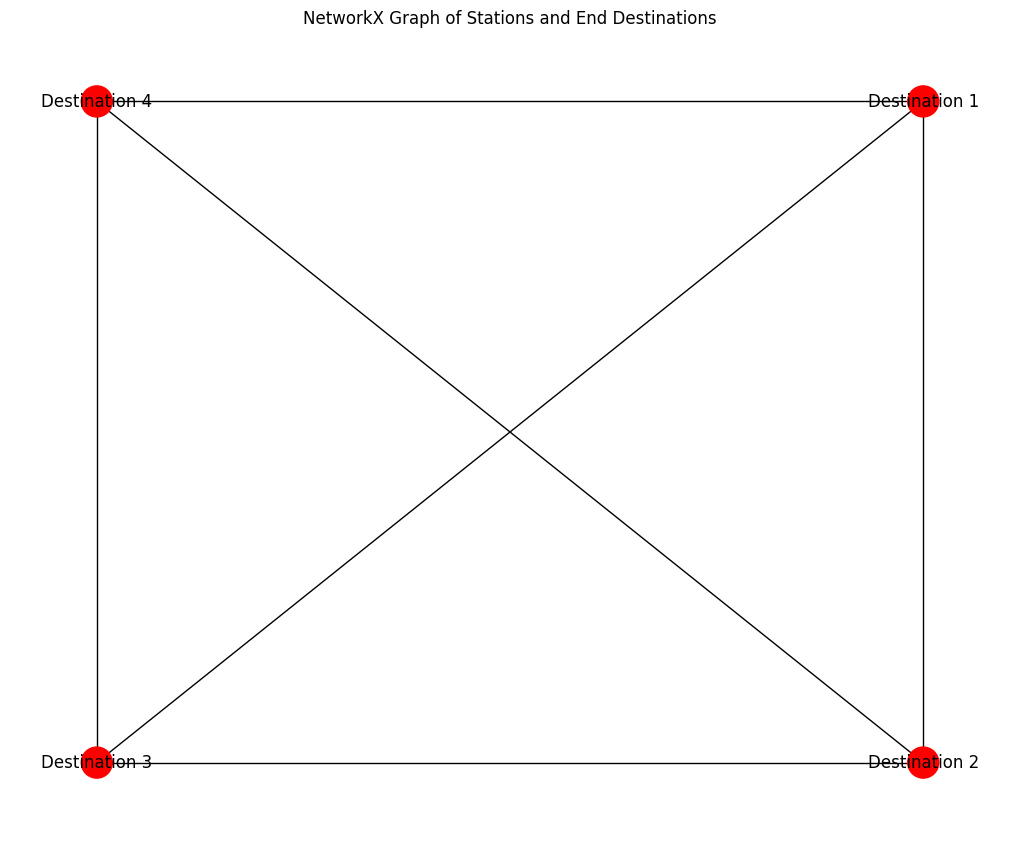

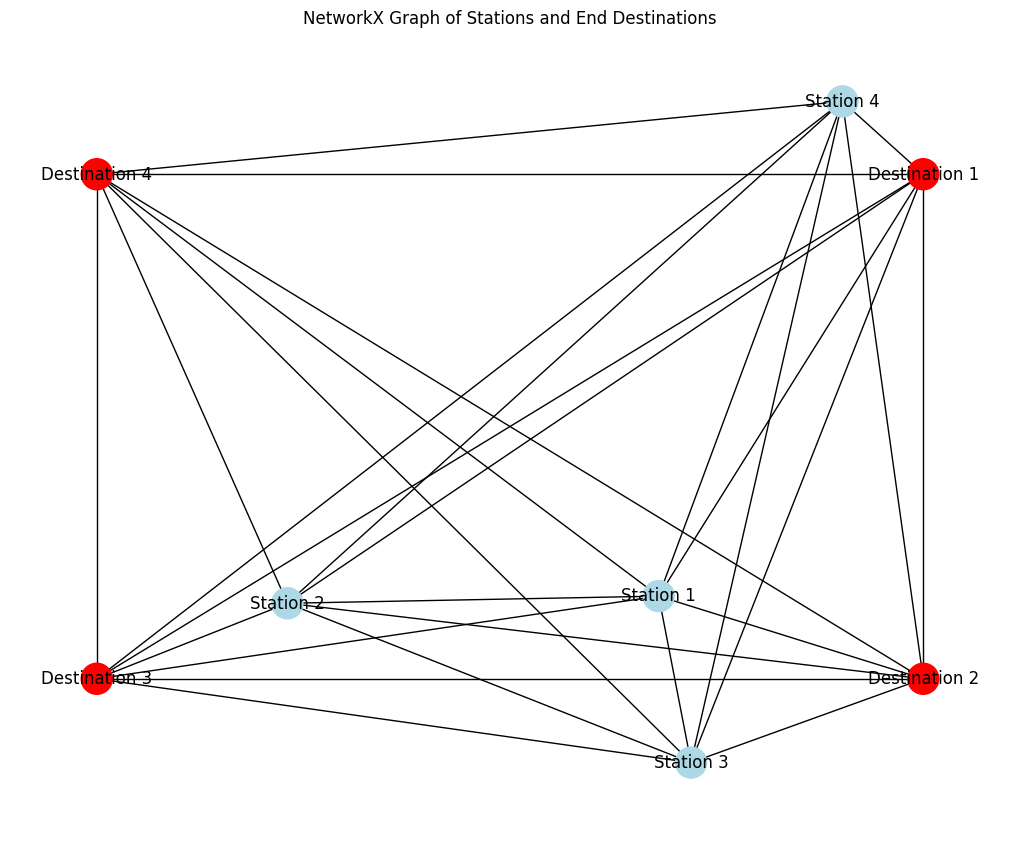

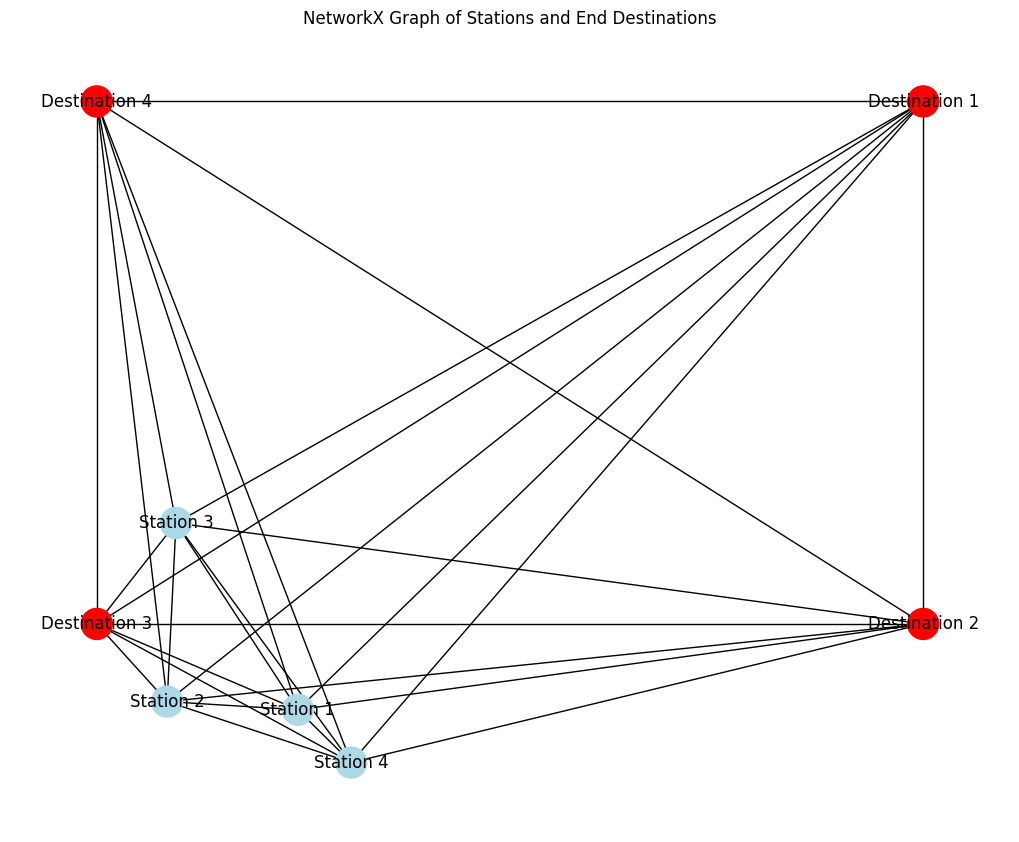

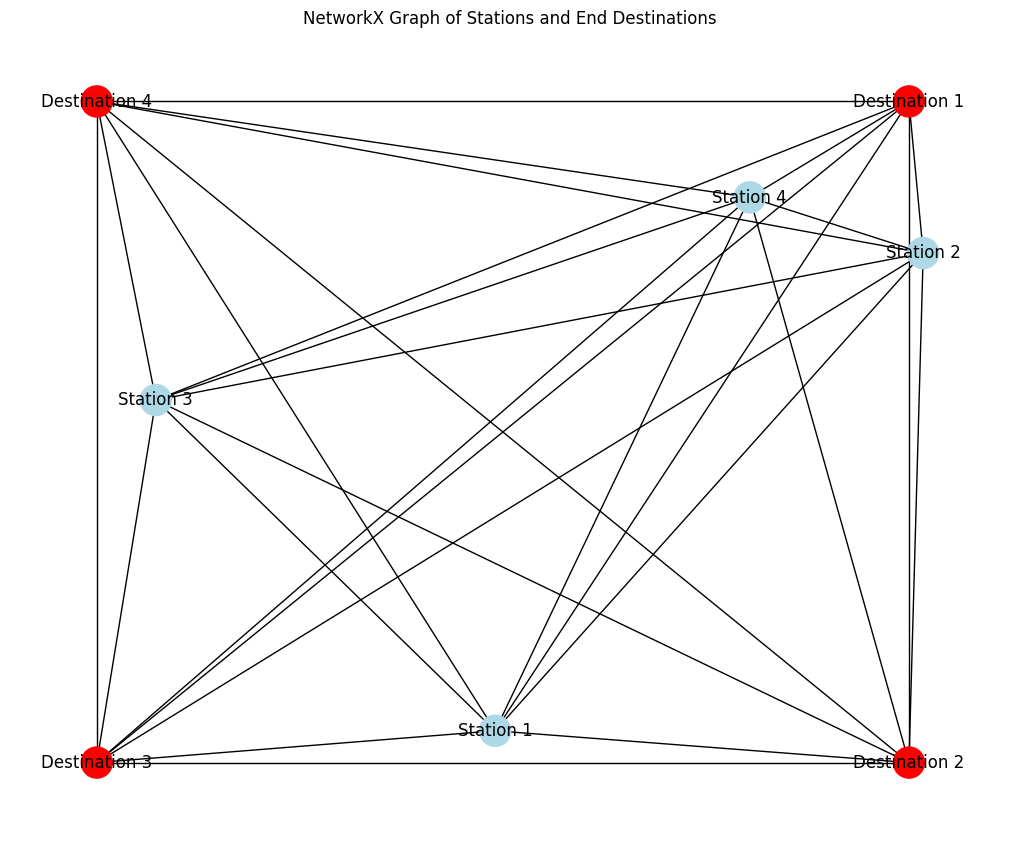

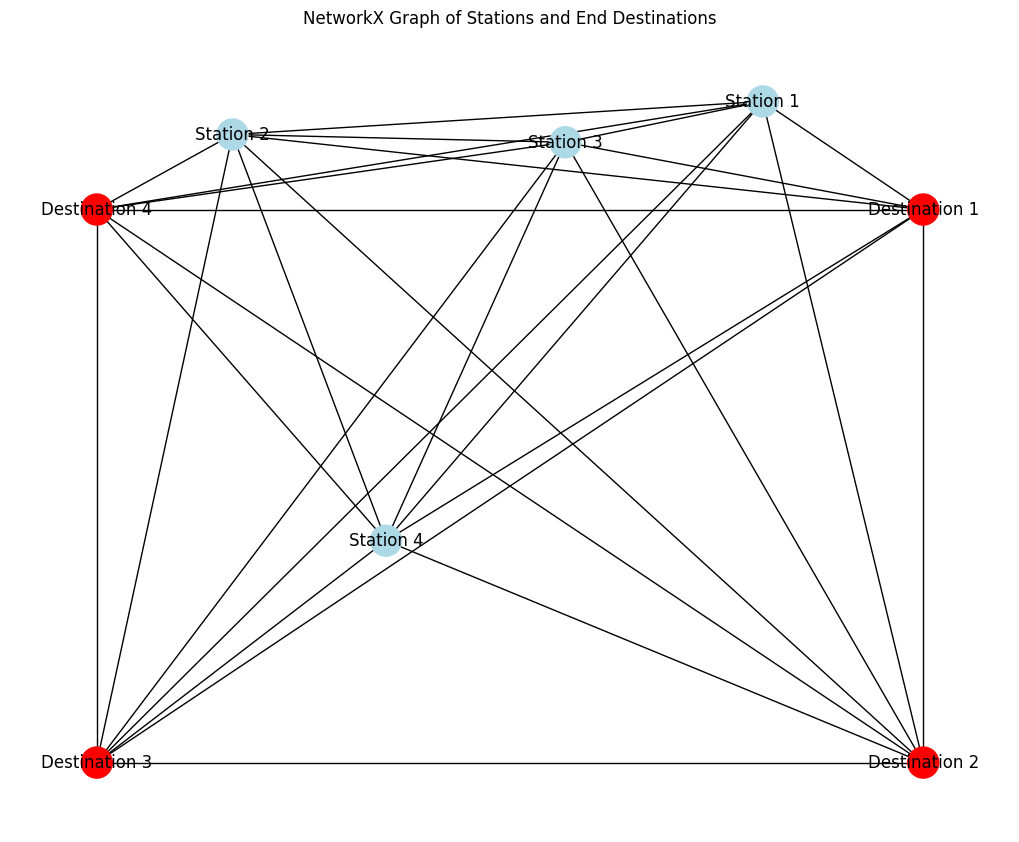

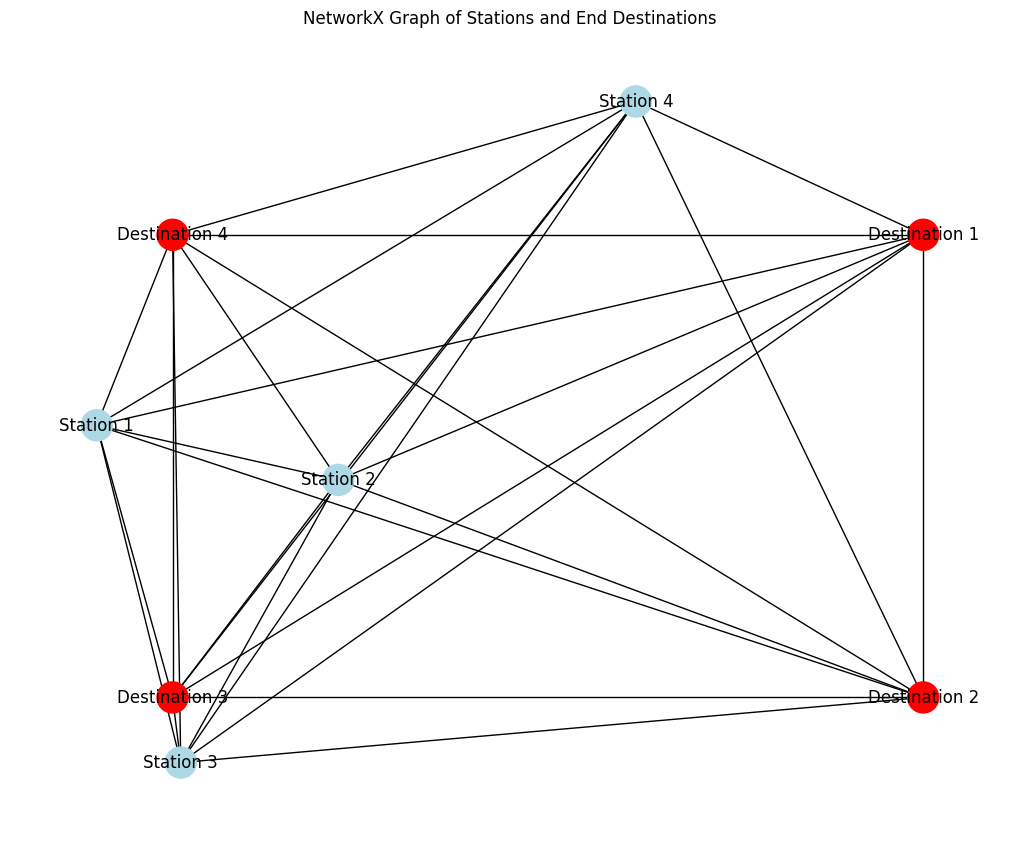

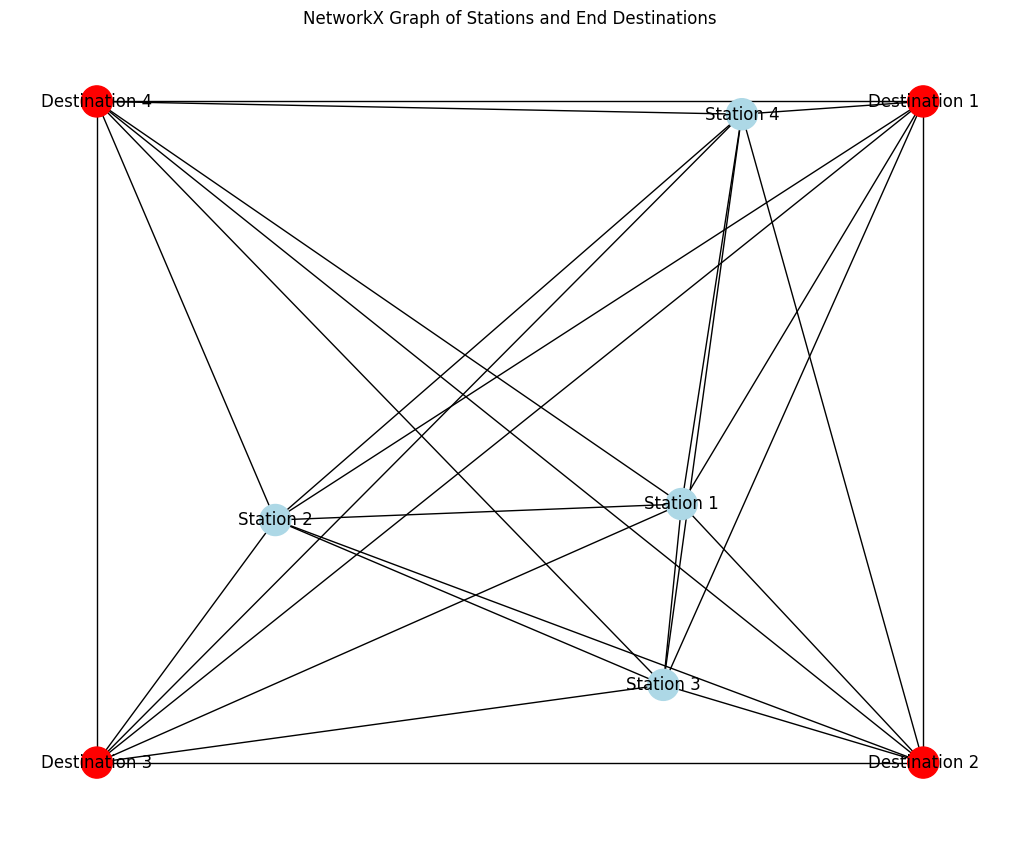

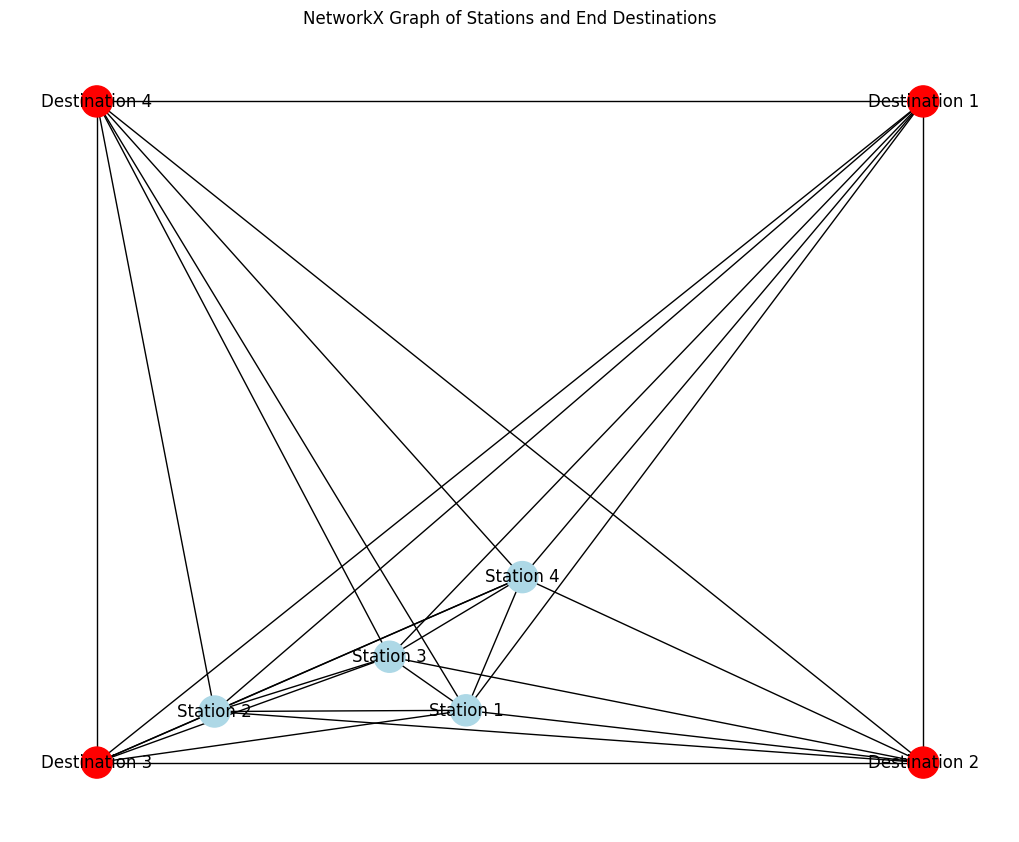

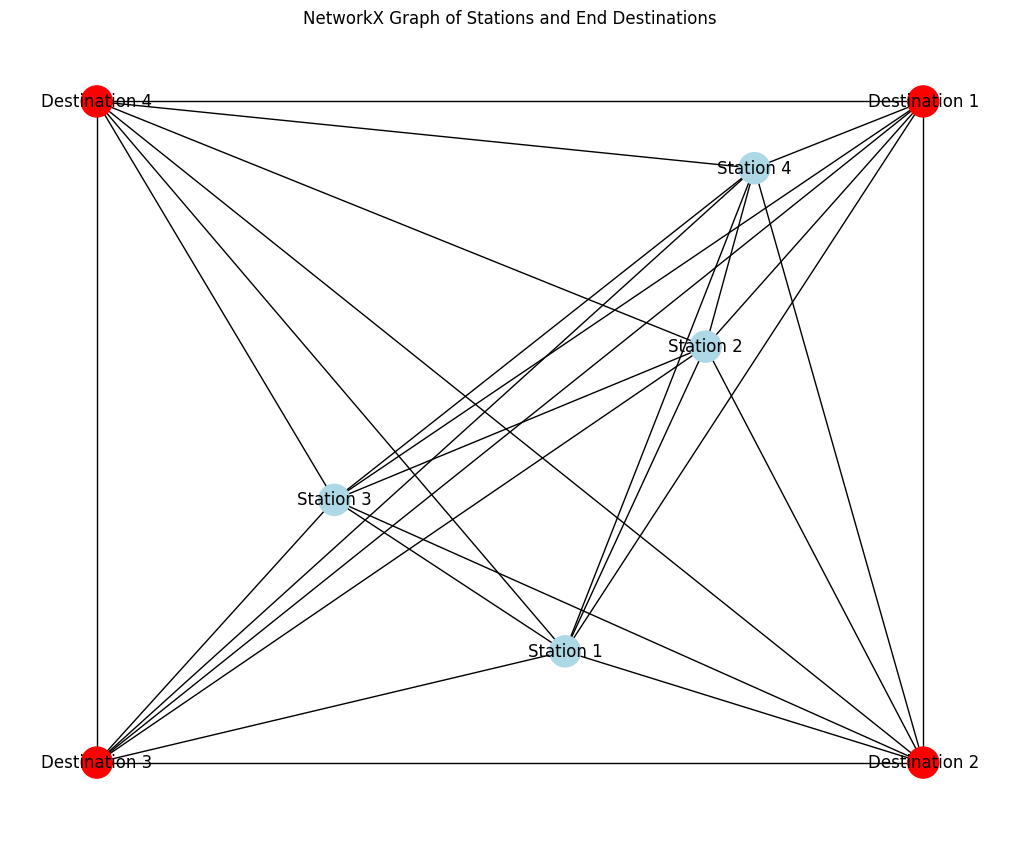

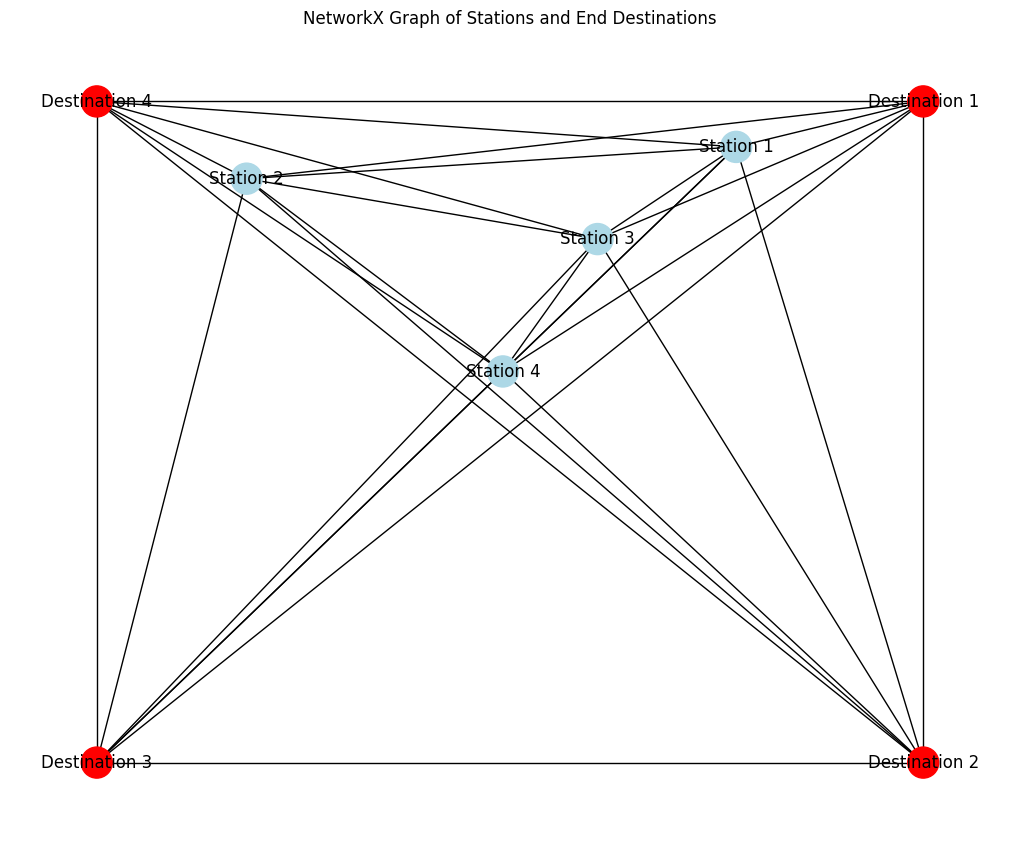

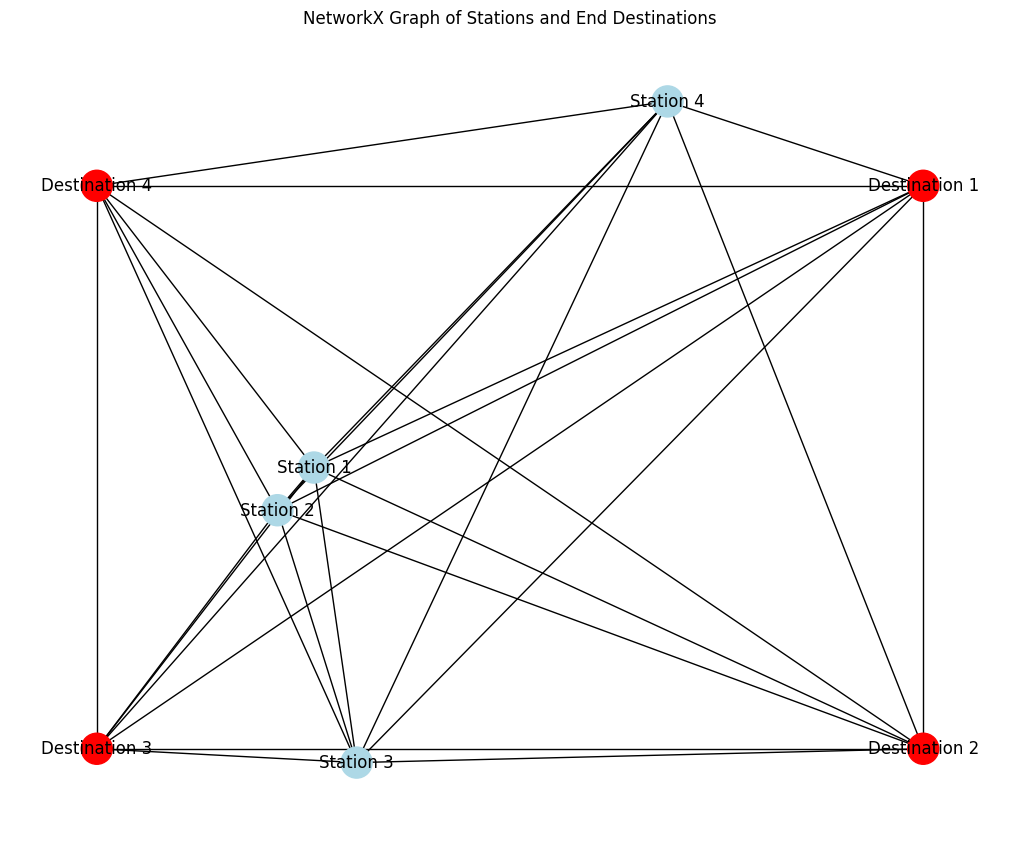

KeyboardInterrupt: 

In [ ]:
destinations = [i for i in G.nodes if G.nodes[i]['type'] == 'destination']

destinationcoords = [(pos[i][0], pos[i][1]) for i in destinations]
G,s,d = gf.create_graph_from_coordinates([], destinationcoords)
citymap = [(-10,-10), (10,10)] + destinationcoords

def fitness(coordinatelist):
    destinations = coordinatelist["destination"]
    stations = coordinatelist["station"]
    G, s, d, = gf.create_graph_from_coordinates(stations, destinations)
    model = MyModel(100, seed=1, G=G)
    for i in range(1000):
        model.step()
    return model.time_saved_ratio()[2]

optimizer = ps.PSO(citymap, fitness, 0.5,0.5,0.5)
bestpos, bestfit = optimizer.optimize(5, 4, 100)
print(bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]

G, s, d, = gf.create_graph_from_coordinates(stations, destinationcoords)